In [2]:
%load_ext Cython

In [3]:
%%cython
from cython.parallel import prange

cdef int i
cdef long int n = 300000000
cdef long int sum = 0

for i in prange(n, nogil=True):
    sum += i

print(sum)

44999999850000000


In [72]:
import itertools
from copy import copy,deepcopy
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
from tqdm import tqdm
import pynauty
import threading
import multiprocessing as mp
from pathos.multiprocessing import Pool
from pqdm.processes import pqdm
from p_tqdm import p_map, p_umap, p_imap, p_uimap
from sympy.combinatorics.permutations import Permutation

In [5]:
from funcs import parallel_process

In [6]:
def enumerate2(xs, start=0, step=1):
    for x in xs:
        yield (start, x)
        start += step

In [47]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(1,len(s)))

In [8]:
def measure(func, *args):
    time_start = time.time()
    result = func(*args)
    time_end = time.time()
    print(f'{func.__name__}: {time_end - time_start}')
    return result

# Concurent TQDM

In [9]:
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed

def parallel_process(array, function, n_jobs=16, use_kwargs=False, front_num=3):
    """
        A parallel version of the map function with a progress bar. 

        Args:
            array (array-like): An array to iterate over.
            function (function): A python function to apply to the elements of array
            n_jobs (int, default=16): The number of cores to use
            use_kwargs (boolean, default=False): Whether to consider the elements of array as dictionaries of 
                keyword arguments to function 
            front_num (int, default=3): The number of iterations to run serially before kicking off the parallel job. 
                Useful for catching bugs
        Returns:
            [function(array[0]), function(array[1]), ...]
    """
    #We run the first few iterations serially to catch bugs
    if front_num > 0:
        front = [function(**a) if use_kwargs else function(a) for a in array[:front_num]]
    #If we set n_jobs to 1, just run a list comprehension. This is useful for benchmarking and debugging.
    if n_jobs==1:
        return front + [function(**a) if use_kwargs else function(a) for a in tqdm(array[front_num:])]
    #Assemble the workers
    with ProcessPoolExecutor(max_workers=n_jobs) as pool:
        #Pass the elements of array into function
        if use_kwargs:
            futures = [pool.submit(function, **a) for a in array[front_num:]]
        else:
            futures = [pool.submit(function, a) for a in array[front_num:]]
        kwargs = {
            'total': len(futures),
            'unit': 'it',
            'unit_scale': True,
            'leave': True
        }
        #Print out the progress as tasks complete
        for f in tqdm(as_completed(futures), **kwargs):
            pass
    out = []
    #Get the results from the futures. 
    for i, future in tqdm(enumerate(futures)):
        try:
            out.append(future.result())
        except Exception as e:
            out.append(e)
    return front + out


# Parallel reading

In [10]:
def parallel_read(file_name):
    # Maximum number of processes we can run at a time
    cpu_count = mp.cpu_count()

    file_size = os.path.getsize(file_name)
    chunk_size = file_size // cpu_count

    # Arguments for each chunk (eg. [('input.txt', 0, 32), ('input.txt', 32, 64)])
    chunk_args = []
    with open(file_name, 'r') as f:
        def is_start_of_line(position):
            if position == 0:
                return True
            # Check whether the previous character is EOL
            f.seek(position - 1)
            return f.read(1) == '\n'

        def get_next_line_position(position):
            # Read the current line till the end
            f.seek(position)
            f.readline()
            # Return a position after reading the line
            return f.tell()

        chunk_start = 0
        # Iterate over all chunks and construct arguments for `process_chunk`
        while chunk_start < file_size:
            chunk_end = min(file_size, chunk_start + chunk_size)

            # Make sure the chunk ends at the beginning of the next line
            while not is_start_of_line(chunk_end):
                chunk_end -= 1

            # Handle the case when a line is too long to fit the chunk size
            if chunk_start == chunk_end:
                chunk_end = get_next_line_position(chunk_end)

            # Save `process_chunk` arguments
            args = (file_name, chunk_start, chunk_end)
            chunk_args.append(args)

            # Move to the next chunk
            chunk_start = chunk_end

    with mp.Pool(cpu_count) as p:
        # Run chunks in parallel
        chunk_results = p.starmap(process_chunk, chunk_args)

    results = []
    # Combine chunk results into `results`
    for chunk_result in chunk_results:
        for result in chunk_result:
            results.append(result)
    return results
def process_chunk(file_name, chunk_start, chunk_end):
    chunk_results = []
    with open(file_name, 'r') as f:
        # Moving stream position to `chunk_start`
        f.seek(chunk_start)

        # Read and process lines until `chunk_end`
        for line in f:
            chunk_start += len(line)
            if chunk_start > chunk_end:
                break
            chunk_results.append(process_line(line))
    return chunk_results

In [11]:
def process_line(line):
    # Count frequency for every character
    counter = {}
    for letter in line:
        if letter not in counter:
            counter[letter] = 0
        counter[letter] += 1

    # Find the character with the most frequency using `counter`
    most_frequent_letter = None
    max_count = 0
    for key, value in counter.items():
        if value >= max_count:
            max_count = value
            most_frequent_letter = key
    return most_frequent_letter


def serial_read(file_name):
    results = []
    with open(file_name, 'r') as f:
        for line in f:
            results.append(process_line(line))
    return results

In [12]:
measure(parallel_read, 'Graphs/graph9')

parallel_read: 2.24037504196167


['\n',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 '\n',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 '\n',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 '\n',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 '\n',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 '\n',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 '\n',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 '\n',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 '\n',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 '\n',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 '\n',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 '\n',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 '\n',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 '\n',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 '\n',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 

# Boolean sentance

In [13]:
class subset:
    # conjucted subset
    def __init__(self,vertexes : set):
        self.subset = vertexes;

In [14]:
class Logical_block:
    #(a1 v a2 v a3 v...v an)
    def __init__(self,subsets : list):
        self.block = subsets;
    def simplify(self):
        self.block.sort(key=len);
        n = len(self.block)
        i = 0
        while i < n:
            j = i + 1
            while j < n:
                if self.block[i] <= self.block[j]:
                    self.block.pop(j)
                    n -= 1
                else:
                    j += 1
            i += 1
    def __mul__(self, other):
        out = Logical_block([x.union(y) for x in self.block for y in other.block])
        out.simplify()
        return out
    def __len__(self):
        return len(self.block)
    def show(self):
        print('(',end='')
        print(*self.block,sep='v',end=')')

In [15]:
class Logical_sentance:
    def __init__(self,subsets : list):
        self.body = subsets;
    def from_cnf_to_dnf(self):
        for i in range(0,len(self.body)-1):
            f = self.body.pop()
            s = self.body.pop()
            self.body.insert(0,f*s)
    def show(self):
        for i in self.body:
            i.show()
    def sort(self):
        self.body.sort(key=len)
    def to_list_for_dnf(self):
        #only for dnf
        return self.body[0].block

# Graph

In [89]:
""" A Python Class
A simple Python graph class, demonstrating the essential 
facts and functionalities of graphs.
"""


class Graph(object):

    def __init__(self, graph_dict=None):
        """ initializes a graph object 
            If no dictionary or None is given, 
            an empty dictionary will be used
        """
        if graph_dict == None:
            self.__graph_dict = {}
        if type(graph_dict) == dict:
            self.__graph_dict = graph_dict
        elif type(graph_dict) == list:
            self.__graph_dict = {}
            for pair in graph_dict:
                l = list(pair)
                if (l[0] in self.__graph_dict):
                    self.__graph_dict[l[0]].append(l[1])
                else:
                    self.__graph_dict[l[0]] = [l[1]]
                if (l[1] in self.__graph_dict):
                    self.__graph_dict[l[1]].append(l[0])
                else:
                    self.__graph_dict[l[1]] = [l[0]]
    def adjacency_dict(self):
        return self.__graph_dict
    def vertices(self):
        """ returns the vertices of a graph """
        return sorted(list(self.__graph_dict.keys()),key=lambda x: int(x))

    def edges(self):
        """ returns the edges of a graph """
        return self.__generate_edges()
    
    def add_vertex(self, vertex):
        """ If the vertex "vertex" is not in 
            self.__graph_dict, a key "vertex" with an empty
            list as a value is added to the dictionary. 
            Otherwise nothing has to be done. 
        """
        if vertex not in self.__graph_dict:
            self.__graph_dict[vertex] = []

    def add_edge(self, edge):
        """ assumes that edge is of type set, tuple or list; 
            between two vertices can be multiple edges! 
        """
        edge = set(edge)
        (vertex1, vertex2) = tuple(edge)
        if vertex1 in self.__graph_dict:
            self.__graph_dict[vertex1].append(vertex2)
        else:
            self.__graph_dict[vertex1] = [vertex2]
        if vertex2 in self.__graph_dict:
            self.__graph_dict[vertex2].append(vertex1)
        else:
            self.__graph_dict[vertex2] = [vertex1]

    def __generate_edges(self):
        """ A static method generating the edges of the 
            graph "graph". Edges are represented as sets 
            with one (a loop back to the vertex) or two 
            vertices 
        """
        edges = []
        for vertex in self.__graph_dict:
            for neighbour in self.__graph_dict[vertex]:
                if neighbour != vertex:
                    if sorted([neighbour, vertex],key=lambda x: int(x)) not in edges:
                        edges.append(sorted([vertex, neighbour],key=lambda x: int(x)))
                else:
                    if [neighbour] not in edges:
                        edges.append([neighbour])
        return edges
    
    def __eq__(self, other):
        return self.edges == other.edges
    
    def __eq__(self, other):
        return self.edges != other.edges
    
    def __str__(self):
        res = "vertices: "
        for k in sorted(self.__graph_dict,key=lambda x: int(x)):
            res += str(k) + " "
        res += "\nedges: "
        for edge in sorted(self.__generate_edges()):
            res += str(sorted(edge,key=lambda x: int(x))) + " "
        return res
    def check_connection(self,a,b):
        return b in self.__graph_dict[a]
    def make_antigraph(self):
        out  = {}
        for i in self.vertices():
            out[i] = set(self.vertices()) - set(self.__graph_dict[i]) - {i}
        return Graph(out)
    def make_logical(self):
        sent = []
        for edge in self.edges():
            block = []
            for vertex in edge:
                #block.append(set(vertex))
                block.append(set([vertex]))
            sent.append(Logical_block(block))
        return(Logical_sentance(sent))
    def max_cliques(self):
        anti_graph = self.make_antigraph()
        logical_anti_graph = anti_graph.make_logical()
        logical_anti_graph.from_cnf_to_dnf()
        out = []
        if logical_anti_graph.body == []:
            return [set(self.vertices())]
        for i in logical_anti_graph.body[0].block:
            out.append(set(self.vertices()) - i)
        return out
    def get_subgraph(self,vertices):
        out = {}
        extra = set(self.vertices()) - set(vertices)
        for vertex in vertices:
            out[vertex] = list(set(self.__graph_dict[vertex]) - set(extra))
        return Graph(out)

In [17]:
def demonstrate(graphs,cols,tipe='kamada',title=None,with_labels=False,exeptions=False):
    n=len(graphs)
    fig = plt.figure(figsize=(cols*3,3*n//cols))
    fig.patch.set_facecolor('white') # To make copying possible (white background)
    if title != None:
        fig.suptitle(title, fontsize="x-large")
    for i in range(n):
        plt.subplot(n//cols,cols,i+1)
        g = nx.Graph() # Generate a Networkx object

        for e in graphs[i]:            
            g.add_edge(e[0],e[1])
        try:
            if tipe=='bipartide':
                nx.draw(g, pos=nx.bipartite_layout(g, nx.bipartite.sets(g)[0]))
            else:
                a=eval('nx.'+tipe+'_layout(g)')
                nx.draw(g,pos=a,with_labels=with_labels, node_size=0.1)
        except:
            if exeptions:
                print('exeption_while_drawing')
            nx.draw_kamada_kawai(g, node_size=20)
#         if tipe == 'kamada':
#             if with_labels:
#                 nx.draw(g,with_labels=True, node_size=0.1)
#             else:
#                 nx.draw_kamada_kawai(g, node_size=20)
#         elif tipe == 'shell':
#             if with_labels:
#                 nx.draw(g,pos=nx.shell_layout(g),with_labels=True, node_size=0.1)
#             else:
#                 nx.draw_shell(g, node_size=20)
#         elif tipe == 'bipartite':
#             try:
#                 nx.draw(g, pos=nx.bipartite_layout(g, nx.bipartite.sets(g)[0]))
#             except:
#                 nx.draw_kamada_kawai(g, node_size=20)
    print('.', end='')

In [18]:
def print_graph(graph):
    return str(str(sorted(list(map(lambda x: sorted(x),graph)))).replace("'], ['"," ").replace("', '","").split("]], [["))[4:-4]

In [19]:
def full_graph(graph,vertices,tipe='str'):
    for i in range(0,vertices):
        if (tipe=='str'):
            graph.add_vertex(str(i))
        if (tipe=='int'):
            graph.add_vertex(i)
    return graph

# Hypergraphs

In [20]:
def hypergraph_to_graph(hypergraph):
    out = {}
    for edge in hypergraph:
        e_list = list(edge)
        if len(e_list) == 1:
            out[e_list[0]] = {}
        for i,first in enumerate(e_list):
            for j in range(i+1,len(e_list)):
                if first in out:
                    out[first].add(e_list[j])
                else:
                    out[first] = {e_list[j]}
                if e_list[j] in out:
                    out[e_list[j]].add(first)
                else:
                    out[e_list[j]] = {first}
    return Graph(out)

In [21]:
def dualisation_for_hypergraph(hypergraph):
    sent = []
    for edge in hypergraph:
        block = []
        for vertex in edge:
            block.append(set([vertex]))
        sent.append(Logical_block(block))
    return(Logical_sentance(sent))

# Graph generators

In [22]:
list("[[1],[1,2,3]]")

['[', '[', '1', ']', ',', '[', '1', ',', '2', ',', '3', ']', ']']

In [23]:
#Create list of all graphs on vertices
graphs = []
vertices = 0
def Create_Graphs(vertices):
    vertices = vertices
    f = open('/home/dmitrii/Documents/TI lab/Graphs/graph'+str(vertices), 'r')
    graphs=[]
    cur_graph={}
    for index,line in enumerate(f):
        if index%(vertices+2)==0:
            continue
        if index%(vertices+2)==1:
            cur_graph={}
        if vertices+1>=index%(vertices+2)>=2:
            head,tails = line.split(":")
            cur_graph[str(head.split()[0])] = tails[:-2].split()
        if index%(vertices+2) == vertices+1:
            graphs.append(cur_graph)
    return graphs

In [24]:
#Create list of all bipartite graphs on vertices
def Create_Bigraphs(vertices):
    vertices = vertices
    f = open('/home/dmitrii/Documents/TI lab/Graphs/bigraph'+str(vertices), 'r')
    graphs=[]
    cur_graph={}
    for index,line in enumerate(f):
        if index%(vertices+2)==0:
            continue
        if index%(vertices+2)==1:
            cur_graph={}
        if vertices+1>=index%(vertices+2)>=2:
            head,tails = line.split(":")
            cur_graph[str(head.split()[0])] = tails[:-2].split()
        if index%(vertices+2) == vertices+1:
            graphs.append(cur_graph)
    return graphs

In [25]:
mp.cpu_count()

8

# Parallel proccessing

In [26]:
def parallel_procces_graphs(file_name,vertices,func):
    num_lines = sum(1 for line in open(file_name))
    n_lines = vertices+2
    # Maximum number of processes we can run at a time
    cpu_count = mp.cpu_count()
    file_size = os.path.getsize(file_name)
    chunk_size = ((num_lines//n_lines) // cpu_count) * n_lines
    # Arguments for each chunk (eg. [('input.txt', 0, 32), ('input.txt', 32, 64)])
    chunk_args = []
    with open(file_name, 'r') as f:
        chunk_start = 0
        # Iterate over all chunks and construct arguments for `process_chunk`
        while chunk_start < num_lines:
            chunk_end = min(num_lines, chunk_start + chunk_size)
            # Save `process_chunk` arguments
            args = (file_name, chunk_start, chunk_end,vertices,func)
            chunk_args.append(args)

            # Move to the next chunk
            chunk_start = chunk_end

    with mp.Pool(cpu_count) as p:
        # Run chunks in parallel
        chunk_results = p.starmap(process_graphs, chunk_args)
    results = []
    # Combine chunk results into `results`
    for chunk_result in chunk_results:
        for result in chunk_result:
            results.append(result)
    return results
def process_graphs(file_name, chunk_start, chunk_end,vertices,func):
    chunk_results = []
    with open(file_name, 'r') as f:
        # Moving stream position to `chunk_start`
#         f.seek(chunk_start)

        # Read and process lines until `chunk_end`
#         for line in f:
#             chunk_start += len(line)
#             if chunk_start > chunk_end:
#                 break
#             chunk_results.append(process_line(line))
        for index,line in enumerate(f):
            if index < chunk_start:
                continue
            chunk_start += 1
            if chunk_start > chunk_end:
                break
            if index%(vertices+2)==0:
                continue
            if index%(vertices+2)==1:
                cur_graph={}
            if vertices+1>=index%(vertices+2)>=2:
                head,tails = line.split(":")
                cur_graph[str(head.split()[0])] = tails[:-2].split()
            if index%(vertices+2) == vertices+1:
                chunk_results+=func(cur_graph,vertices)
    return chunk_results

In [27]:
def f(h,vertices):
    c,h_d = check_cdc(h,True)
    h_d = hypergraph_to_graph(h_d)
    h_bar = Graph(h).make_antigraph()
    h_c_bar = h_d.make_antigraph()
    if check_for_many_twin_vertices(Graph(h).edges(),vertices)  or check_for_many_twin_vertices(h_d.edges(),vertices) or check_for_many_twin_vertices(h_bar.edges(),vertices) or check_for_many_twin_vertices(h_c_bar.edges(),vertices):
        return []
    if check_bip(h) or check_bip(h_d.adjacency_dict()) or check_bip(h_bar.adjacency_dict()) or check_bip(h_c_bar.adjacency_dict()):
        return []
    if not isomorphic(Graph(h).edges(),h_c_bar.edges(),vertices) and not isomorphic(h_d.edges(),h_bar.edges(),vertices):
        return []
    if c:
        return [Graph(h).edges(),
        h_d.edges(),
        h_bar.edges(),
        h_c_bar.edges()]
    else:
        return []

In [28]:
def serial_proccess(file_name,vertices,func):
    f = open(file_name, 'r')
    chunk_results = []
    for index,line in enumerate(f):
            if index%(vertices+2)==0:
                continue
            if index%(vertices+2)==1:
                cur_graph={}
            if vertices+1>=index%(vertices+2)>=2:
                head,tails = line.split(":")
                cur_graph[str(head.split()[0])] = tails[:-2].split()
            if index%(vertices+2) == vertices+1:
                chunk_results+=func(cur_graph,vertices)
    #print(chunk_results)
    return chunk_results

In [ ]:
demonstrate(parallel_procces_graphs('Graphs/graph8',8,f),4,tipe='spring',title='self-complement not bipartite',with_labels=True)

In [ ]:
measure(parallel_procces_graphs, 'Graphs/graph9',9,f)

ERROR! Session/line number was not unique in database. History logging moved to new session 238


# Check conformal

In [29]:
def check_if_conformal(hypergraph):
    graph = hypergraph_to_graph(hypergraph)
    max_cliques = graph.max_cliques()
    return str(sorted(list(map(lambda x:sorted(list(x)),hypergraph)))) == str(sorted(list(map(lambda x:sorted(list(x)),max_cliques))))

# Check cdc

In [30]:
def check_cdc(h,return_cdc=False):
    h_d = dualisation_for_hypergraph(Graph(h).max_cliques())
    h_d.from_cnf_to_dnf()
    if return_cdc:
        p = h_d.to_list_for_dnf()
        return check_if_conformal(p), p
    else:
        return check_if_conformal(h_d.to_list_for_dnf())

ERROR! Session/line number was not unique in database. History logging moved to new session 239


# Isomorphism

In [31]:
#def make_automorphic_minimal(graph):
def isomorphic(a,b,n):
    a = Graph(a).adjacency_dict()
    b = Graph(b).adjacency_dict()
    #print(a)
    a = {int(k):[int(i) for i in v] for k,v in a.items()}
    b = {int(k):[int(i) for i in v] for k,v in b.items()}
    return pynauty.isomorphic(pynauty.Graph(n,adjacency_dict=a),pynauty.Graph(n,adjacency_dict=b))

In [32]:
def check_in_isomrphic(h,h_list,v):
    #out = any(p_map(lambda graph: isomorphic(graph,h,v),h_list))
    #return out
    threads = max(min(len(h_list),8),1)
    with Pool(threads) as p:
        #return any(p.map(lambda x: isomorphic(x,h,v),h_list))
        return any(p.map(lambda x: isomorphic(x,h,v),h_list))
#     for graph in h_list:
#         if isomorphic(graph,h,v):
#             return True
#     return False
    #return any(list(map(lambda x: isomorphic(x,h,v),h_list)))

In [33]:
def check_perm(h_neig,g_neig,perm,tipe='str'):
    if tipe == 'str':
        for i,j in enumerate(perm):
            if h_neig[str(i)] != g_neig[str(j)]:
                return False
        return True
    if tipe == 'int':
        for i,j in enumerate(perm):
            if h_neig[i] != g_neig[j]:
                return False
        return True
# for 4 groups of neibs
def find_isomorphism(h,g,vertices,tipe='str'):
    if tipe == 'str':
        _h = full_graph(Graph(h),vertices)
        _g = full_graph(Graph(g),vertices)
    if tipe == 'int':
        _h = full_graph(Graph(h),vertices,tipe='int')
        _g = full_graph(Graph(g),vertices,tipe='int')
    h_neig = dict(list(map(lambda x:(x[0],len(x[1])),_h.adjacency_dict().items())))
    g_neig = dict(list(map(lambda x:(x[0],len(x[1])),_g.adjacency_dict().items())))
    for perm in tqdm(itertools.permutations(_g.vertices()),total= math.factorial(vertices)):
        if sorted([perm[0],perm[1],perm[2],perm[3],perm[4]]) == [5,6,7,8,9]:
            continue
        if not check_perm(h_neig,g_neig,perm,tipe):
            continue
        for vertex_actual,vertex_f in enumerate(perm):
            #print(perm,vertex_actual,vertex_f)
            #print(list(map(lambda x: str(perm[int(x)]),_h.adjacency_dict()[str(vertex_actual)])))
            #print(_g.adjacency_dict()[str(vertex_f)])
            if tipe == 'str':
                if len(_h.adjacency_dict()[str(vertex_actual)]) != len(_g.adjacency_dict()[str(vertex_f)]):
                    break
                ###
                itr=0
                for i in _h.adjacency_dict()[str(vertex_actual)]:
                    if str(perm[int(i)]) not in _g.adjacency_dict()[str(vertex_f)]:
                        break
                    itr+=1
                if itr != len(_h.adjacency_dict()[str(vertex_actual)]):
                    break
                ###
#                 if sorted(list(map(lambda x: str(perm[int(x)]),_h.adjacency_dict()[str(vertex_actual)]))) != sorted(_g.adjacency_dict()[str(vertex_f)]):
#                     #print(sorted(list(map(lambda x: str(perm[int(x)]),_h.adjacency_dict()[str(vertex_actual)]))),sorted(_g.adjacency_dict()[str(vertex_f)]))
#                     break
                if int(vertex_actual) == vertices-1:
                    return perm
            if tipe == 'int':
#                 if len(_h.adjacency_dict()[vertex_actual]) != len(_g.adjacency_dict()[vertex_f]):
#                     break
                ###
                itr=0
                for i in _h.adjacency_dict()[vertex_actual]:
                    if perm[i] not in _g.adjacency_dict()[vertex_f]:
                        break
                    itr+=1
                if itr != len(_h.adjacency_dict()[vertex_actual]):
                    break
                ###
#                 if sorted(list(map(lambda x: perm[int(x)],_h.adjacency_dict()[vertex_actual]))) != sorted(_g.adjacency_dict()[vertex_f]):
#                     #print(sorted(list(map(lambda x: str(perm[int(x)]),_h.adjacency_dict()[str(vertex_actual)]))),sorted(_g.adjacency_dict()[str(vertex_f)]))
#                     break
                if int(vertex_actual) == vertices-1:
                    return perm
    return []

# Siphts

In [34]:
def check_for_anticlique(graph,prob_anticlique):
    for i,k in itertools.combinations(prob_anticlique, 2):
        if graph.check_connection(i,k):
            return False
    return True

In [35]:
def check_split(graph,n):
    actual_g = full_graph(Graph(graph),n)
    max_cliques = actual_g.max_cliques()
    for clique in max_cliques:
        vertics = set(map(str,list(range(0,n))))
        addition = vertics - clique
        #print(clique,vertics,addition)
        if check_for_anticlique(actual_g,addition):
            return True
    return False

In [36]:
def check_for_twin_vertices(graph,n):
    g_dict = full_graph(Graph(graph),n).adjacency_dict()
    for i,k in itertools.combinations(g_dict.values(), 2):
        #print(i,k)
        if sorted(i) == sorted(k):
            return True
    return False

In [37]:
def DFS(G,v,seen=None,path=None):
    if seen is None: seen = []
    if path is None: path = [v]

    seen.append(v)

    paths = []
    for t in G[v]:
        if t not in seen:
            t_path = path + [t]
            paths.append(tuple(t_path))
            paths.extend(DFS(G, t, seen[:], t_path))
    return paths
def find_longest_path(graph,n):
    # Build graph dictionary
    #G = defaultdict(list)
    #print(G)
    G = full_graph(Graph(graph),n).adjacency_dict()
    # Run DFS, compute metrics
    all_paths = DFS(G, '1')
    max_len   = max(len(p) for p in all_paths) if len(all_paths) > 0 else 0
    #max_paths = [p for p in all_paths if len(p) == max_len]
    return max_len
    # Output
    #print("All Paths:")
    #print(all_paths)
    #print("Longest Paths:")
    #for p in max_paths: print("  ", p)
    #print("Longest Path Length:")
    #print(max_len)

In [38]:
def check_for_many_twin_vertices(graph,n,out=False):
    g_dict = full_graph(Graph(graph),n).adjacency_dict()
    for subset in powerset(set(g_dict.keys())):
        adjacency_list = []
        for vertex in subset:
            adjacency_list.append(g_dict[vertex])
        x = list(map(lambda x: list(set(x) - set(subset)),adjacency_list))
        if x.count(x[0]) == len(x):
            if out:
                print(subset)
            return True
    return False

# Bipartide

In [39]:
# Function to check whether a graph is
# bipartite or not
def isBipartite(adj, visited, color,started_v='1',v='1'):
    for u in adj[v]:
        # If vertex u is not explored before
        if (visited.get(u) == None):

            # Mark present vertic as visited
            visited[u] = True

            # Mark its color opposite to its parent
            color[u] = not (color.get(v) if color.get(v) != None else False)

            # If the subtree rooted at vertex v
            # is not bipartite
            if (not isBipartite(adj,visited, color,started_v, u)):
                return False
        # If two adjacent are colored with
        # same color then the graph is not
        # bipartite
        elif (color[u] == color[v]):
            return False
    if v == started_v and len(adj.keys()) > len(visited.keys()):
        v = list(set(adj.keys()) - set(visited.keys()))[0]
        visited[v] = True
        color[v] = 0
        return isBipartite(adj,visited, color,v, v)
    return True

In [40]:
def check_bip(h):
    visited={'1':True}
    color={'1':0}
    return isBipartite(h,visited,color)

# Two cliques

In [41]:
def bip_from_two_cliques(graph,clique1,clique2,n):
    actual_g = graph.adjacency_dict().copy()
    for vertex in clique1:
        actual_g[vertex] = sorted(list(set(actual_g[vertex]) - set(clique1)))
    for vertex in clique2:
        actual_g[vertex] = sorted(list(set(actual_g[vertex]) - set(clique2)))
    return Graph(actual_g).edges()

In [42]:
def check_two_cliques(graph,n):
    actual_g = full_graph(Graph(graph),n)
    max_cliques = actual_g.max_cliques()
    for clique in max_cliques:
        if len(clique) == 1 or len(clique) >= n-1:
            continue
        vertics = set(map(str,list(range(0,n))))
        addition = vertics - clique
        #print(clique,vertics,addition)
        if check_for_anticlique(actual_g.make_antigraph(),addition):
            return True,min(len(clique),len(addition)),bip_from_two_cliques(actual_g,clique,addition,n)
    return False,0,[]

 # Subtransversial

In [42]:
def covering_check(S,selection,H):
    selection_v = set()
    for edge in selection:
        selection_v |= edge
    selection_v -= S
    for edge in H:
        if edge.issubset(selection_v):
            return True
    return False
# False - not_covering exists True - not covering not exists -> False - transv, True - subtransvers
def subselection(edges,S_last,S_took,H):
    if len(S_last) == 0:
        if not covering_check(S_took | S_last,edges,H):
            #print(edges)
            return False
        return True
    Took_vertex = next(iter(S_last))
    S_last.remove(Took_vertex)
    S_took.add(Took_vertex)
    _S = S_took | S_last
    _S.remove(Took_vertex)
    for edge in H:
        if len(edge & _S) != 0 or Took_vertex not in edge:
            continue
        edges.append(edge)
        if not subselection(edges,S_last,S_took,H):
            return False
        edges.pop()
    return True
#существует ненакрывающая выборка размера size на гиперграфе H, в котором n вершин
def create_all_selections(H,n,size=None):
    if size == None:
        size = n
    for S in list(powerset(list(map(str,list(range(n)))))):
        if len(S) > size:
            return False,[]
        if len(S) == size and not subselection([],set(S),set(),H):
            return True,S
    return False,[]
print(create_all_selections([{'1', '4'}, {'3', '0', '4'}],5,2))

(True, ('0', '1'))


# Code

## Find isomorphism of specific pair

In [47]:
g1 = {'0':['1','4','5'],'1' : ['0','2','6'],'2' : ['1','3','7'],'3':['2','4','8'],'4':['0','3','9'],'5':['0'],'6':['1'],'7':['2'],'8':['3'],'9':['4']}

In [48]:
g2 = {'0':['1','4','5','10'],'1' : ['0','2','6','11'],'2' : ['1','3','7'],'3':['2','4','8'],'4':['0','3','9'],'5':['0'],'6':['1'],'7':['2'],'8':['3'],'9':['4'],'10':['0','11'],'11':['1','10']}

In [40]:
g2 = {0:[1,4,5,10],1 : [0,2,6,11],2 : [1,3,7],3:[2,4,8],4:[0,3,9],5:[0],6:[1],7:[2],8:[3],9:[4],10:[0,11],11:[1,10]}

In [41]:
g3 = {'0':['1','4','5','10'],'1' : ['0','2','6','11','12'],'2' : ['1','3','7','13'],'3':['2','4','8'],'4':['0','3','9'],'5':['0'],'6':['1'],'7':['2'],'8':['3'],'9':['4'],'10':['0','11'],'11':['1','10'],'12':['1','13'],'13':['2','12']}

In [42]:
g3 = {0:[1,4,5,10],1 : [0,2,6,11,12],2 : [1,3,7,13],3:[2,4,8],4:[0,3,9],5:[0],6:[1],7:[2],8:[3],9:[4],10:[0,11],11:[1,10],12:[1,13],13:[2,12]}

In [43]:
g4 = {'0':['1','4','5','10'],'1' : ['0','2','6','11'],'2' : ['1','3','7','12'],'3':['2','4','8','13'],'4':['0','3','9'],'5':['0'],'6':['1'],'7':['2'],'8':['3'],'9':['4'],'10':['0','11'],'11':['1','10'],'12':['2','13'],'13':['3','12']}

In [59]:
g4 = {0:[1,4,5,10],1 : [0,2,6,11],2 : [1,3,7,12],3:[2,4,8,13],4:[0,3,9],5:[0],6:[1],7:[2],8:[3],9:[4],10:[0,11],11:[1,10],12:[2,13],13:[3,12]}

In [44]:
g5 = {'0':['1','4','5','10'],'1' : ['0','2','6','11','12'],'2' : ['1','3','7','13'],'3':['2','4','8','14'],'4':['0','3','9','15'],'5':['0'],'6':['1'],'7':['2'],'8':['3'],'9':['4'],'10':['0','11'],'11':['1','10'],'12':['1','13'],'13':['2','12'],'14':['3','15'],'15':['4','14']}

In [45]:
g5 = {0:[1,4,5,10],1 : [0,2,6,11,12],2 : [1,3,7,13],3:[2,4,8,14],4:[0,3,9,15],5:[0],6:[1],7:[2],8:[3],9:[4],10:[0,11],11:[1,10],12:[1,13],13:[2,12],14:[3,15],15:[4,14]}

In [ ]:
g6 = {'0':['1','4','5','10','12'],'1' : ['0','2','6','11','13'],'2' : ['1','3','7'],'3':['2','4','8'],'4':['0','3','9'],'5':['0'],'6':['1'],'7':['2'],'8':['3'],'9':['4'],'10':['0','11'],'11':['1','10'],'12':['0','13'],'13':['1','12']}

In [68]:
g6 = {0:[1,4,5,10,12],1 : [0,2,6,11,13],2 : [1,3,7],3:[2,4,8],4:[0,3,9],5:[0],6:[1],7:[2],8:[3],9:[4],10:[0,11],11:[1,10],12:[0,13],13:[1,12]}

In [79]:
h=g6
h_list=[]
vertices=14
c,h_d = check_cdc(h,True)
h_d = full_graph(hypergraph_to_graph(h_d),vertices=vertices,tipe='int')
h_bar = Graph(h).make_antigraph()
h_c_bar = h_d.make_antigraph()
if check_for_many_twin_vertices(Graph(h).edges(),vertices)  or check_for_many_twin_vertices(h_d.edges(),vertices,out=True) or check_for_many_twin_vertices(h_bar.edges(),vertices,out=True) or check_for_many_twin_vertices(h_c_bar.edges(),vertices,out=True):
    print(1)
#elif check_bip(h) or check_bip(h_d.adjacency_dict()) or check_bip(h_bar.adjacency_dict()) or check_bip(h_c_bar.adjacency_dict()):
#    print(0)
#el
if c and not check_in_isomrphic(h,h_list,vertices):
    h_list.append(Graph(h).edges())
    h_list.append(h_d.edges())
    h_list.append(h_bar.edges())
    h_list.append(h_c_bar.edges())

1


In [80]:
pic_sifted = []
first = []
second = []
third = []
for i,k,j,m in zip(h_list[0::4], h_list[1::4],h_list[2::4], h_list[3::4]):
    if check_cdc(j) and check_cdc(m):
        if isomorphic(k,j,vertices):
            #print(Graph(k).adjacency_dict(),list(map(len,Graph(k).adjacency_dict().values())))
            #print(Graph(j).adjacency_dict(),list(map(len,Graph(j).adjacency_dict().values())))
            print(find_isomorphism(k,j,vertices,tipe='int'))
            second.append(i)
            second.append(k)
            second.append(j)
            second.append(m)
        else:
            third.append(i)
            third.append(k)
            third.append(j)
            third.append(m)

  0%|                                                   | 0/120 [00:00<?, ?it/s]

(5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 10, 11, 12, 13)
(5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 10, 11, 13, 12)
(5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 10, 12, 11, 13)
(5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 10, 12, 13, 11)
(5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 10, 13, 11, 12)
(5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 10, 13, 12, 11)
(5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 11, 10, 12, 13)
(5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 11, 10, 13, 12)
(5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 11, 10, 13, 12)


.

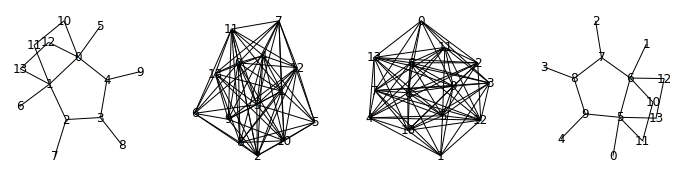

In [77]:
demonstrate(second,4,tipe='kamada_kawai',with_labels=True)

In [64]:
from pqdm.processes import pqdm
# If you want threads instead:
# from pqdm.threads import pqdm

args = [1, 2, 3, 4, 5]
# args = range(1,6) would also work

def square(a):
    return a*a

result = pqdm(args, square, n_jobs=2)

QUEUEING TASKS | :   0%|          | 0/5 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/5 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/5 [00:00<?, ?it/s]

In [227]:
list(map(lambda x: [x],list(range(14))))

[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13]]

## $G$ ismorphic $G^c$

In [128]:
vertices = 9
graphs = Create_Graphs(vertices)

In [129]:
first = []
second = []
for h in tqdm(graphs):
    c,h_d = check_cdc(h,True)
    if c:
        h_d = hypergraph_to_graph(h_d).adjacency_dict()
        h_bar = Graph(h).make_antigraph()
        if   (isomorphic(h,h_d,vertices)) and not check_for_many_twin_vertices(Graph(h).edges(),vertices,out = True):
            if (isomorphic(h,h_bar.adjacency_dict(),vertices)):
                first.append(Graph(h).edges())
                first.append(Graph(h_d).edges())
                first.append(h_bar.edges())
            else:
                second.append(Graph(h).edges())
                second.append(Graph(h_d).edges())

 11%|███▌                              | 29213/274668 [00:16<02:28, 1649.30it/s]

('3', '2')


 18%|██████                            | 48791/274668 [00:28<02:15, 1662.72it/s]

('6', '7')


 19%|██████▍                           | 52143/274668 [00:30<02:11, 1694.06it/s]

('1', '2')


 29%|█████████▊                        | 79545/274668 [00:46<01:45, 1855.75it/s]

('8', '7')


 33%|███████████                       | 89478/274668 [00:51<01:44, 1768.62it/s]

('6', '7')


 56%|██████████████████▌              | 154271/274668 [01:29<01:15, 1603.57it/s]

('6', '5')


 58%|███████████████████▎             | 160499/274668 [01:33<01:17, 1473.13it/s]

('6', '1', '3', '7', '0', '4')


 60%|███████████████████▋             | 163598/274668 [01:35<01:11, 1549.85it/s]

('6', '1', '2', '4')
('8', '7')


 64%|█████████████████████▏           | 176067/274668 [01:42<01:01, 1598.81it/s]

('6', '7')


 71%|███████████████████████▍         | 194985/274668 [01:54<00:48, 1642.35it/s]

('6', '1', '3', '0', '5', '4')


100%|█████████████████████████████████| 274668/274668 [02:45<00:00, 1661.91it/s]


.

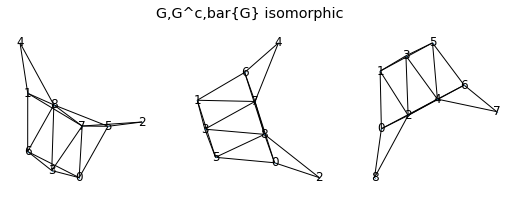

In [130]:
demonstrate(first,3,title='G,G^c,bar{G} isomorphic',tipe='spring',with_labels=True)

.

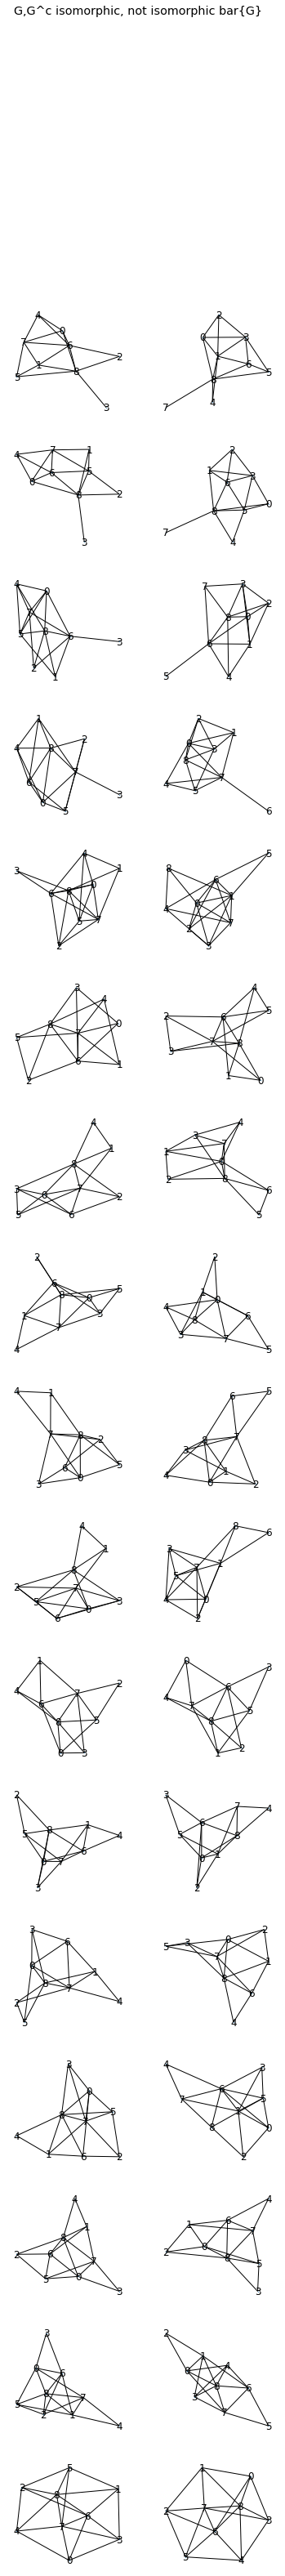

In [131]:
demonstrate(second,2,title='G,G^c isomorphic, not isomorphic bar{G}',tipe='spring',with_labels=True)

## 4 - $G$,$G^c$,$\bar{G}$,$\bar{G^c}$

In [55]:
vertices = 8
graphs = Create_Graphs(vertices)

In [56]:
h_list = []
for h in tqdm(graphs):
    c,h_d = check_cdc(h,True)
    h_d = hypergraph_to_graph(h_d)
    h_bar = Graph(h).make_antigraph()
    h_c_bar = h_d.make_antigraph()
    if check_for_many_twin_vertices(Graph(h).edges(),vertices)  or check_for_many_twin_vertices(h_d.edges(),vertices) or check_for_many_twin_vertices(h_bar.edges(),vertices) or check_for_many_twin_vertices(h_c_bar.edges(),vertices):
        continue
    if check_bip(h) or check_bip(h_d.adjacency_dict()) or check_bip(h_bar.adjacency_dict()) or check_bip(h_c_bar.adjacency_dict()):
        continue
    if c and not check_in_isomrphic(h,h_list,vertices):
        h_list.append(Graph(h).edges())
        h_list.append(h_d.edges())
        h_list.append(h_bar.edges())
        h_list.append(h_c_bar.edges())

 48%|█████████████████▉                   | 5974/12346 [00:31<00:25, 251.18it/s]Process ForkPoolWorker-1099:
Process ForkPoolWorker-1100:
Process ForkPoolWorker-1102:
Process ForkPoolWorker-1101:
Process ForkPoolWorker-1097:
Process ForkPoolWorker-1098:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/dmitrii/.local/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/home/dmitrii/.local/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/home/dmitrii/.local/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/dmitrii/.local/lib/python3.8/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/dmitrii/.l

[[['0', '5'], ['0', '6'], ['0', '7'], ['1', '5'], ['1', '7'], ['2', '6'], ['2', '7'], ['3', '6'], ['4', '7'], ['5', '6'], ['5', '7'], ['6', '7']], [['6', '7'], ['3', '7'], ['1', '6'], ['4', '6'], ['5', '6'], ['2', '3'], ['1', '3'], ['3', '4'], ['3', '5'], ['0', '3'], ['1', '2'], ['1', '4'], ['0', '1'], ['2', '4'], ['4', '5'], ['0', '4'], ['2', '5'], ['0', '2']], [['0', '1'], ['0', '2'], ['0', '4'], ['0', '3'], ['1', '6'], ['1', '2'], ['1', '3'], ['1', '4'], ['2', '3'], ['2', '4'], ['2', '5'], ['3', '4'], ['3', '7'], ['3', '5'], ['4', '6'], ['4', '5']], [['0', '5'], ['0', '7'], ['0', '6'], ['1', '5'], ['1', '7'], ['2', '7'], ['2', '6'], ['3', '6'], ['4', '7'], ['5', '7']], [['0', '4'], ['0', '6'], ['0', '7'], ['1', '5'], ['1', '7'], ['2', '6'], ['2', '7'], ['3', '7'], ['6', '7']], [['1', '6'], ['1', '3'], ['1', '2'], ['1', '4'], ['1', '7'], ['0', '1'], ['4', '6'], ['3', '4'], ['4', '7'], ['4', '5'], ['0', '7'], ['5', '7'], ['0', '6'], ['0', '3'], ['0', '2'], ['0', '5'], ['3', '6'], ['2'

  File "/home/dmitrii/.local/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/home/dmitrii/.local/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/home/dmitrii/.local/lib/python3.8/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dmitrii/.local/lib/python3.8/site-packages/multiprocess/pool.py", line 114, in worker
    task = get()
  File "/home/dmitrii/.local/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/home/dmitrii/.local/lib/python3.8/site-packages/multiprocess/pool.py", line 114, in worker
    task = get()
  File "/home/dmitrii/.local/lib/python3.8/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dmitrii/.local/lib/python3.8/site-packages/multiprocess/process.py", line 108, in run
    self

KeyboardInterrupt: 

In [52]:
pic_sifted = []
first = []
second = []
third = []
for i,k,j,m in zip(h_list[0::4], h_list[1::4],h_list[2::4], h_list[3::4]):
    if  not check_for_many_twin_vertices(i,vertices)  and not check_for_many_twin_vertices(k,vertices)and not check_for_many_twin_vertices(j,vertices) and not check_for_many_twin_vertices(m,vertices):
                pic_sifted.append(i)
                pic_sifted.append(k)
                pic_sifted.append(j)
                pic_sifted.append(m)
                """
                if isomorphic(k,j,vertices) and  isomorphic(i,m,vertices):
                    print('isomorphic',end=' ')
                    first.append(i)
                    first.append(k)
                    first.append(j)
                    first.append(m)
                    #plot_graphs([i,k,j,m], figsize=14, dotsize=20)
                """

                """
                elif  isomorphic(i,m,vertices):
                    print('2',end=' ')
                    second.append(i)
                    second.append(k)
                    second.append(j)
                    second.append(m)
                    #plot_graphs([i,k,j,m], figsize=14, dotsize=20)
                """
                """
                if not isomorphic(k,j,vertices):
                    print('3',end=' ')
                    third.append(i)
                    third.append(k)
                    third.append(j)
                    third.append(m)
                """
                """
                if check_cdc(i) and check_cdc(k):
                    print("first pair")
                    second.append(i)
                    second.append(k)
                    second.append(j)
                    second.append(m)
                """
                if check_cdc(j) and check_cdc(m):
                    if isomorphic(k,j,vertices):
                        second.append(i)
                        second.append(k)
                        second.append(j)
                        second.append(m)
                        if isomorphic(i,k,vertices):
                            first.append(i)
                            first.append(k)
                            first.append(j)
                            first.append(m)
                    else:
                        third.append(i)
                        third.append(k)
                        third.append(j)
                        third.append(m)
"""
n=len(third)
fig = plt.figure(figsize=(4*3,3*n//4))
fig.patch.set_facecolor('white') # To make copying possible (white background)
for i in range(n):
    plt.subplot(n//4,4,i+1)
    g = nx.Graph() # Generate a Networkx object

    for e in third[i]:            
        g.add_edge(e[0],e[1])
    #nx.draw_kamada_kawai(g, node_size=20)
    nx.draw_shell(g, node_size=20)
    print('.', end='')
"""

"\nn=len(third)\nfig = plt.figure(figsize=(4*3,3*n//4))\nfig.patch.set_facecolor('white') # To make copying possible (white background)\nfor i in range(n):\n    plt.subplot(n//4,4,i+1)\n    g = nx.Graph() # Generate a Networkx object\n\n    for e in third[i]:            \n        g.add_edge(e[0],e[1])\n    #nx.draw_kamada_kawai(g, node_size=20)\n    nx.draw_shell(g, node_size=20)\n    print('.', end='')\n"

In [53]:
demonstrate(first,4,tipe='circular',title='all 4 isomorphic',with_labels=True)

.

<Figure size 864x0 with 0 Axes>

In [54]:
# rename = {'3':0,
#          '0':1,
#          '5':2,
#          '2':3,
#          '7':4,
#          '8':5,
#          '4':6,
#          '1':7,
#          '6':8}
# pos={1: np.array([-0.50000005,  0.8660254 ]),
#      0: np.array([0.17364823, 0.98480774]),
#      2: np.array([-0.9396926 ,  0.34202023]),
#      8: np.array([0.76604444, 0.64278759]),
#      4: np.array([-0.4999999 , -0.86602542]),
#      7: np.array([1.00000000e+00, 1.98682148e-08]),
#      6: np.array([ 0.76604432, -0.64278773]),
#      5: np.array([ 0.17364817, -0.9848077 ]),
#      3: np.array([-0.9396926 , -0.34202013])}
rename = {'3':0,
         '8':1,
         '4':2,
         '1':3,
         '6':4,
         '0':5,
         '5':6,
         '2':7,
         '7':8}
pos={1: np.array([-0.50000005,  0.8660254 ]),
     0: np.array([0.17364823, 0.98480774]),
     2: np.array([-0.9396926 ,  0.34202023]),
     8: np.array([0.76604444, 0.64278759]),
     4: np.array([-0.4999999 , -0.86602542]),
     7: np.array([1.00000000e+00, 1.98682148e-08]),
     6: np.array([ 0.76604432, -0.64278773]),
     5: np.array([ 0.17364817, -0.9848077 ]),
     3: np.array([-0.9396926 , -0.34202013])}
graphs=first
cols=4
with_labels=True
exeptions=False
title=None
tipe='circular'
n=len(graphs)
fig = plt.figure(figsize=(cols*3,3*n//cols))
fig.patch.set_facecolor('white') # To make copying possible (white background)
if title != None:
    fig.suptitle(title, fontsize="x-large")
for i in range(n):
    plt.subplot(n//cols,cols,i+1)
    g = nx.Graph() # Generate a Networkx object

    for e in graphs[i]:
        g.add_edge(rename[e[0]],rename[e[1]])
    try:
        if tipe=='bipartide':
            nx.draw(g, pos=nx.bipartite_layout(g, nx.bipartite.sets(g)[0]))
        else:
            a=eval('nx.'+tipe+'_layout(g)')
            print(a)
            
            nx.draw(g,pos=pos,with_labels=with_labels, node_size=0.1)
    except:
        if exeptions:
            print('exeption_while_drawing')
        nx.draw_kamada_kawai(g, node_size=20)

<Figure size 864x0 with 0 Axes>

# Selfcompliment not bipartite

In [66]:
vertices = 9
graphs = Create_Graphs(vertices)

In [67]:
h_list = []
for h in tqdm(graphs):
    c,h_d = check_cdc(h,True)
    h_d = hypergraph_to_graph(h_d)
    h_bar = Graph(h).make_antigraph()
    h_c_bar = h_d.make_antigraph()
    if check_for_many_twin_vertices(Graph(h).edges(),vertices)  or check_for_many_twin_vertices(h_d.edges(),vertices) or check_for_many_twin_vertices(h_bar.edges(),vertices) or check_for_many_twin_vertices(h_c_bar.edges(),vertices):
        continue
    if check_bip(h) or check_bip(h_d.adjacency_dict()) or check_bip(h_bar.adjacency_dict()) or check_bip(h_c_bar.adjacency_dict()):
        continue
    ####
    #if not isomorphic(Graph(h).edges(),h_c_bar.edges(),vertices) and not isomorphic(h_d.edges(),h_bar.edges(),vertices):
    #   continue
    ####
    if c and not check_in_isomrphic(h,h_list,vertices):
        h_list.append(Graph(h).edges())
        h_list.append(h_d.edges())
        h_list.append(h_bar.edges())
        h_list.append(h_c_bar.edges())

100%|████████████████████████████████| 274668/274668 [21:45:51<00:00,  3.51it/s]


In [68]:
pic_sifted = []
first = []
second = []
third = []
for i,k,j,m in zip(h_list[0::4], h_list[1::4],h_list[2::4], h_list[3::4]):
    if  not check_for_many_twin_vertices(i,vertices)  and not check_for_many_twin_vertices(k,vertices)and not check_for_many_twin_vertices(j,vertices) and not check_for_many_twin_vertices(m,vertices):
                pic_sifted.append(i)
                pic_sifted.append(k)
                pic_sifted.append(j)
                pic_sifted.append(m)
                if check_cdc(j) and check_cdc(m):
                    if isomorphic(k,j,vertices):
                        second.append(i)
                        second.append(k)
                        second.append(j)
                        second.append(m)
                        if isomorphic(i,m,vertices):
                            print(find_isomorphism(k,j,vertices),find_isomorphism(i,m,vertices))
                            first.append(i)
                            first.append(k)
                            first.append(j)
                            first.append(m)
                    else:
                        third.append(i)
                        third.append(k)
                        third.append(j)
                        third.append(m)

 62%|███████████████████▎           | 226709/362880 [00:00<00:00, 689891.03it/s]


('5', '4', '8', '7', '1', '0', '6', '3', '2') ('5', '4', '8', '7', '1', '0', '6', '3', '2')


 62%|███████████████████▎           | 225988/362880 [00:00<00:00, 787760.98it/s]


('5', '4', '7', '8', '1', '0', '6', '2', '3') ('5', '4', '7', '8', '1', '0', '6', '2', '3')


  1%|▍                                | 4142/362880 [00:00<00:00, 528804.28it/s]


('0', '1', '7', '6', '4', '5', '3', '2', '8') ('0', '1', '7', '6', '4', '5', '3', '2', '8')


 51%|███████████████▊               | 185522/362880 [00:00<00:00, 829959.15it/s]


('4', '5', '7', '6', '0', '1', '3', '2', '8') ('4', '5', '7', '6', '0', '1', '3', '2', '8')


 36%|███████████▎                   | 131846/362880 [00:00<00:00, 864088.90it/s]


('3', '2', '1', '0', '7', '6', '5', '4', '8') ('3', '2', '1', '0', '7', '6', '5', '4', '8')


 36%|███████████▎                   | 131842/362880 [00:00<00:00, 973627.60it/s]


('3', '2', '1', '0', '7', '5', '8', '4', '6') ('3', '2', '1', '0', '7', '5', '8', '4', '6')


 35%|██████████▊                    | 126827/362880 [00:00<00:00, 812065.77it/s]


('3', '1', '2', '0', '8', '5', '7', '6', '4') ('3', '1', '2', '0', '8', '5', '7', '6', '4')


  0%|                                  | 475/362880 [00:00<00:01, 275864.64it/s]


('0', '1', '2', '6', '8', '7', '3', '5', '4') ('0', '1', '2', '6', '8', '7', '3', '5', '4')


 24%|███████▌                        | 86130/362880 [00:00<00:00, 678262.33it/s]


('2', '1', '0', '6', '7', '8', '3', '4', '5') ('2', '1', '0', '6', '7', '8', '3', '4', '5')


  7%|██                              | 23737/362880 [00:00<00:00, 565679.71it/s]


('0', '5', '6', '8', '7', '1', '2', '4', '3') ('0', '5', '6', '8', '7', '1', '2', '4', '3')


 40%|████████████▎                  | 144820/362880 [00:00<00:00, 588460.10it/s]


('3', '5', '7', '0', '8', '1', '6', '2', '4') ('3', '5', '7', '0', '8', '1', '6', '2', '4')


  7%|██▏                             | 24821/362880 [00:00<00:00, 418536.70it/s]


('0', '5', '8', '3', '7', '1', '6', '4', '2') ('0', '5', '8', '3', '7', '1', '6', '4', '2')


.

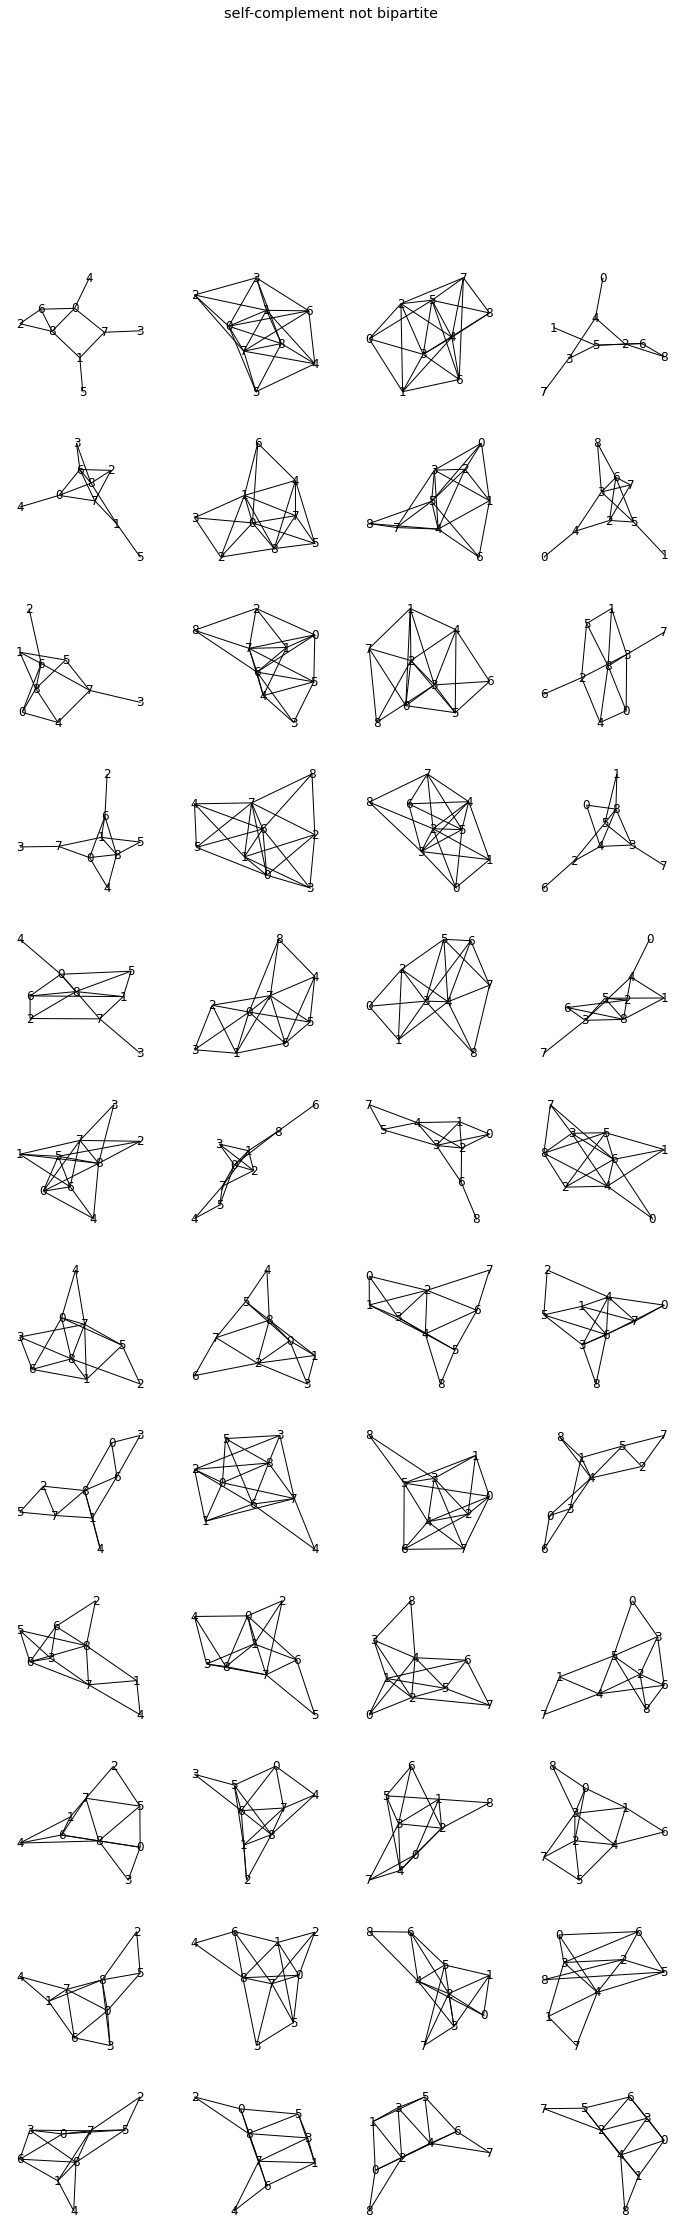

In [69]:
demonstrate(first,4,tipe='spring',title='self-complement not bipartite',with_labels=True)

In [62]:
def find_all_isomorphisms(h,g,vertices,out,tipe='str'):
    temp_out = []
    if tipe == 'str':
        _h = full_graph(Graph(h),vertices)
        _g = full_graph(Graph(g),vertices)
    if tipe == 'int':
        _h = full_graph(Graph(h),vertices,tipe='int')
        _g = full_graph(Graph(g),vertices,tipe='int')
    h_neig = dict(list(map(lambda x:(x[0],len(x[1])),_h.adjacency_dict().items())))
    g_neig = dict(list(map(lambda x:(x[0],len(x[1])),_g.adjacency_dict().items())))
    for perm in tqdm(itertools.permutations(_g.vertices()),total= math.factorial(vertices)):
        if sorted([perm[0],perm[1],perm[2],perm[3],perm[4]]) == [5,6,7,8,9]:
            continue
        if not check_perm(h_neig,g_neig,perm,tipe):
            continue
        for vertex_actual,vertex_f in enumerate(perm):
            #print(perm,vertex_actual,vertex_f)
            #print(list(map(lambda x: str(perm[int(x)]),_h.adjacency_dict()[str(vertex_actual)])))
            #print(_g.adjacency_dict()[str(vertex_f)])
            if tipe == 'str':
                if len(_h.adjacency_dict()[str(vertex_actual)]) != len(_g.adjacency_dict()[str(vertex_f)]):
                    break
                ###
                itr=0
                for i in _h.adjacency_dict()[str(vertex_actual)]:
                    if str(perm[int(i)]) not in _g.adjacency_dict()[str(vertex_f)]:
                        break
                    itr+=1
                if itr != len(_h.adjacency_dict()[str(vertex_actual)]):
                    break
                ###
#                 if sorted(list(map(lambda x: str(perm[int(x)]),_h.adjacency_dict()[str(vertex_actual)]))) != sorted(_g.adjacency_dict()[str(vertex_f)]):
#                     #print(sorted(list(map(lambda x: str(perm[int(x)]),_h.adjacency_dict()[str(vertex_actual)]))),sorted(_g.adjacency_dict()[str(vertex_f)]))
#                     break
                if int(vertex_actual) == vertices-1:
                    temp_out.append(perm)
            if tipe == 'int':
#                 if len(_h.adjacency_dict()[vertex_actual]) != len(_g.adjacency_dict()[vertex_f]):
#                     break
                ###
                itr=0
                for i in _h.adjacency_dict()[vertex_actual]:
                    if perm[i] not in _g.adjacency_dict()[vertex_f]:
                        break
                    itr+=1
                if itr != len(_h.adjacency_dict()[vertex_actual]):
                    break
                ###
#                 if sorted(list(map(lambda x: perm[int(x)],_h.adjacency_dict()[vertex_actual]))) != sorted(_g.adjacency_dict()[vertex_f]):
#                     #print(sorted(list(map(lambda x: str(perm[int(x)]),_h.adjacency_dict()[str(vertex_actual)]))),sorted(_g.adjacency_dict()[str(vertex_f)]))
#                     break
                if int(vertex_actual) == vertices-1:
                    temp_out.append(perm)
    out.append(temp_out)

In [63]:
all_isomorphs = []
pic_sifted = []
first = []
second = []
third = []
for i,k,j,m in zip(h_list[0::4], h_list[1::4],h_list[2::4], h_list[3::4]):
    if  not check_for_many_twin_vertices(i,vertices)  and not check_for_many_twin_vertices(k,vertices)and not check_for_many_twin_vertices(j,vertices) and not check_for_many_twin_vertices(m,vertices):
                pic_sifted.append(i)
                pic_sifted.append(k)
                pic_sifted.append(j)
                pic_sifted.append(m)
                if check_cdc(j) and check_cdc(m):
                    if isomorphic(k,j,vertices):
                        second.append(i)
                        second.append(k)
                        second.append(j)
                        second.append(m)
                        if isomorphic(i,m,vertices):
                            find_all_isomorphisms(k,j,vertices,all_isomorphs)
                            find_all_isomorphisms(i,m,vertices,all_isomorphs)
                            first.append(i)
                            first.append(k)
                            first.append(j)
                            first.append(m)
                    else:
                        third.append(i)
                        third.append(k)
                        third.append(j)
                        third.append(m)

100%|███████████████████████████████████| 5040/5040 [00:00<00:00, 668393.85it/s]


In [64]:
list(map(lambda x: list(map(lambda y: Permutation(y).full_cyclic_form,x)),all_isomorphs))

[[[[0, 4], [1, 3], [2, 6], [5]]], [[[0, 4], [1, 3], [2, 6], [5]]]]

In [65]:
len(first)

4

In [52]:
def f(h,vertices):
    c,h_d = check_cdc(h,True)
    h_d = hypergraph_to_graph(h_d)
    h_bar = Graph(h).make_antigraph()
    h_c_bar = h_d.make_antigraph()
    if check_for_many_twin_vertices(Graph(h).edges(),vertices)  or check_for_many_twin_vertices(h_d.edges(),vertices) or check_for_many_twin_vertices(h_bar.edges(),vertices) or check_for_many_twin_vertices(h_c_bar.edges(),vertices):
        return []
    if check_bip(h) or check_bip(h_d.adjacency_dict()) or check_bip(h_bar.adjacency_dict()) or check_bip(h_c_bar.adjacency_dict()):
        return []
    if not isomorphic(Graph(h).edges(),h_c_bar.edges(),vertices) and not isomorphic(h_d.edges(),h_bar.edges(),vertices):
        return []
    if c:
        return [Graph(h).edges(),
        h_d.edges(),
        h_bar.edges(),
        h_c_bar.edges()]
    else:
        return []

In [57]:
vertices = 10
h_list = parallel_procces_graphs('Graphs/graph'+str(vertices),vertices,f)
first = []
for i,k,j,m in zip(h_list[0::4], h_list[1::4],h_list[2::4], h_list[3::4]):
    if not check_in_isomrphic(i,first,vertices):
        first.append(i)
        first.append(k)
        first.append(j)
        first.append(m)

KeyboardInterrupt: 

.

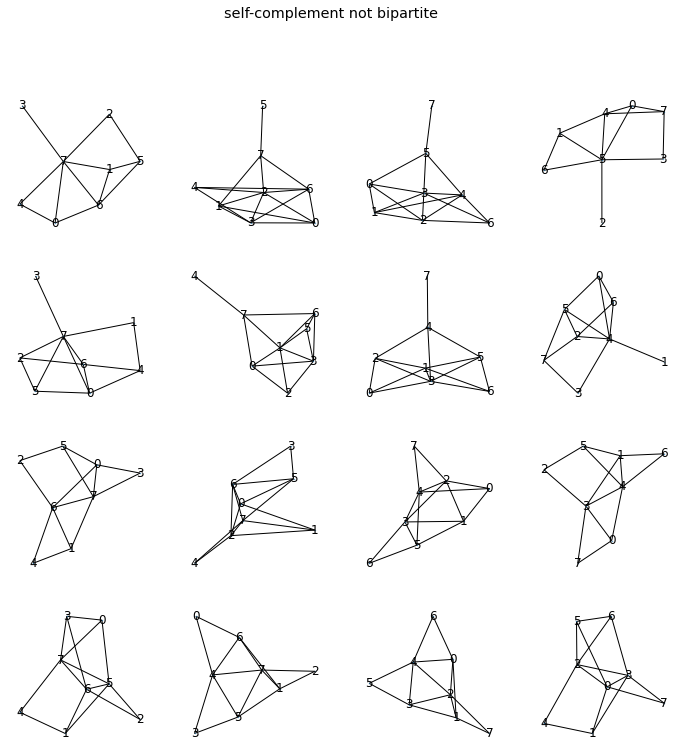

In [59]:
demonstrate(first,4,tipe='spring',title='self-complement not bipartite',with_labels=True)

# 16-vert shitty shit

## center of simmetry through 2 vert 

In [106]:
core = Graph({0:[1],1:[0,2],2:[1,3],3:[2,4],4:[3,5],5:[4,6],6:[5,7],7:[6,8],8:[7]})

.

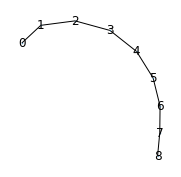

In [107]:
demonstrate([core.edges()],1,tipe='spring',with_labels=True)

In [118]:
def make_16_v_simm_graph1(perm):
    new_g = deepcopy(core)
    for i in range(9,16):
        new_g.add_vertex(i)
        new_g.add_edge((i-1,i))
    new_g.add_edge([0,15])
    for edge in perm:
        new_g.add_edge(edge)
        new_g.add_edge([abs(edge[0]-16) % 16,abs(edge[1]-16) % 16])
    return new_g
    ###
#     pos={0: np.array([-0.9238795 , -0.38268346]),
#          1: np.array([-0.70710671, -0.70710689]),
#          2: np.array([-0.38268358, -0.92387944]),
#          3: np.array([ 1.19248806e-08, -1.00000000e+00]),
#          4: np.array([ 0.38268358, -0.92387944]),
#          5: np.array([ 0.70710701, -0.70710653]),
#          6: np.array([ 0.92387956, -0.38268343]),
#          7: np.array([1.00000000e+00, 1.74845553e-07]),
#          8: np.array([0.92387956, 0.38268331]),
#          9: np.array([0.70710677, 0.70710677]),
#          10: np.array([0.38268328, 0.92387962]),
#          11: np.array([-3.37766238e-07,  1.00000000e+00]),
#          12: np.array([-0.38268387,  0.92387933]),
#          13: np.array([-0.70710659,  0.70710701]),
#          14: np.array([-0.9238795 ,  0.38268355]),
#          15: np.array([-1.00000000e+00, -8.74227766e-08])}

#     g = nx.Graph() # Generate a Networkx object
#     for e in new_g.edges():
#         g.add_edge(e[0],e[1])
#     nx.draw(g,pos=pos,with_labels=True, node_size=0.1)
#     ###

In [119]:
make_16_v_simm_graph1(((0, 4), (1, 6), (2, 7)))

In [125]:
def demonstrate16(graphs,cols):
    n=len(graphs)
    fig = plt.figure(figsize=(cols*3,3*n//cols))
    fig.patch.set_facecolor('white') # To make copying possible (white background)

    for i in range(n):
        plt.subplot(n//cols,cols,i+1)

        pos={0: np.array([-0.9238795 , -0.38268346]),
         1: np.array([-0.70710671, -0.70710689]),
         2: np.array([-0.38268358, -0.92387944]),
         3: np.array([ 1.19248806e-08, -1.00000000e+00]),
         4: np.array([ 0.38268358, -0.92387944]),
         5: np.array([ 0.70710701, -0.70710653]),
         6: np.array([ 0.92387956, -0.38268343]),
         7: np.array([1.00000000e+00, 1.74845553e-07]),
         8: np.array([0.92387956, 0.38268331]),
         9: np.array([0.70710677, 0.70710677]),
         10: np.array([0.38268328, 0.92387962]),
         11: np.array([-3.37766238e-07,  1.00000000e+00]),
         12: np.array([-0.38268387,  0.92387933]),
         13: np.array([-0.70710659,  0.70710701]),
         14: np.array([-0.9238795 ,  0.38268355]),
         15: np.array([-1.00000000e+00, -8.74227766e-08])}

        g = nx.Graph() # Generate a Networkx object
        for e in graphs[i]:
            g.add_edge(e[0],e[1])
        nx.draw(g,pos=pos,with_labels=True, node_size=0.1)

In [130]:
len([(i,j) for i,j in list(itertools.combinations([0,1,2,3,4,5,6,7,8],2)) if (i+1 != j)])

28

In [142]:
h_list = []
with open('16v_graphs1.txt','w') as data: 
    for perm in tqdm(powerset([(i,j) for i,j in list(itertools.combinations([0,1,2,3,4,5,6,7,8],2)) if (i+1 != j)]),total = 268435456):
        #h_list.append(make_16_v_simm_graph1(perm).edges())
        if len(perm) > 2:
            break
        data.write(str(make_16_v_simm_graph1(perm).adjacency_dict())+"\n")

  0%|                              | 406/268435456 [00:00<4:10:55, 17829.79it/s]


ValueError: num must be 1 <= num <= 405, not 406

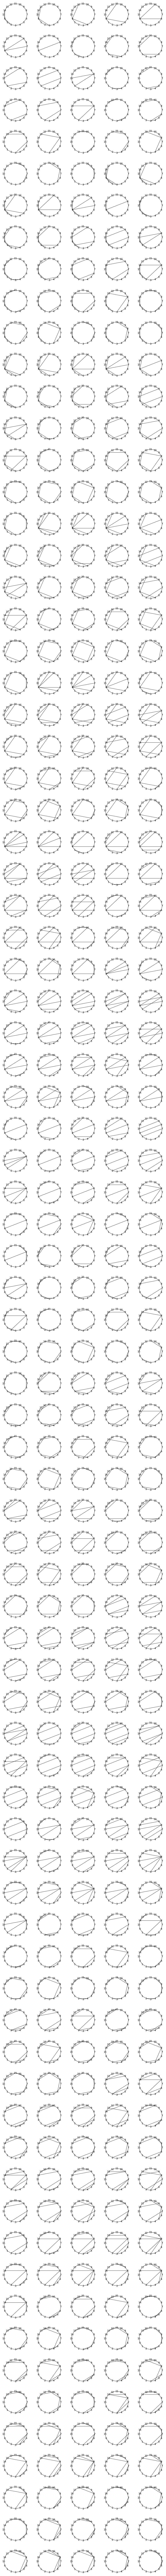

In [127]:
demonstrate16(h_list,5)

## subtransv shit

In [32]:
subselection([],{'1','2','5'},set(),[{'1','2'},{'2','3'},{'3','4'},{'4','5'}])

True

In [34]:
vertices = 8
graphs = Create_Graphs(vertices)
h_list = []
for g in tqdm(graphs):
    c,h_d = check_cdc(g,True)
    g=Graph(g).edges()
    g_d = hypergraph_to_graph(h_d).edges()
    # and not check_for_many_twin_vertices(Graph(g).edges(),vertices)
    if not c:
        h = Graph(g).max_cliques()
        vertices_l = list(map(str,list(range(vertices))))
        g_n = list(map(set,[edge for edge in list(itertools.combinations(vertices_l, 2)) if subselection([],set(edge),set(),h)]))
        graph = nx.Graph()
        for e in Graph(g_n).edges():            
            graph.add_edge(e[0],e[1])
        all_cliques= nx.enumerate_all_cliques(graph)
        triad_cliques=[x for x in all_cliques if len(x)==3 ]
        for triangle in triad_cliques:
            if not subselection([],set(triangle),set(),h):
                print(triangle)
                h_list.append(g)

100%|███████████████████████████████████| 12346/12346 [00:08<00:00, 1438.47it/s]


In [30]:
demonstrate(h_list,1,with_labels=True)

.

<Figure size 216x0 with 0 Axes>